In [25]:
import os
import re
import pandas as pd
import numpy as np

def process_gesture_data(file_path):
    df = pd.read_csv(file_path, header=None)
    df = df.iloc[:, 1:].reset_index(drop=True)  # 移除时间列
    
    empty_rows = df[(df == 0).all(axis=1)].index.tolist()
    print(f"Detected empty rows at indices: {empty_rows}")
    
    gestures = []
    start_idx = 0
    for idx in empty_rows + [len(df)]:
        if start_idx < idx:
            gestures.append(df.iloc[start_idx:idx].reset_index(drop=True))
        start_idx = idx + 1
    processed_gestures = []
    for i, gesture in enumerate(gestures):
        data = gesture.to_numpy()
        # print(f"Processing Trial {i+1} of Gesture with {data.shape[0]} samples")
        if data.shape[0] > 1000:
            data = data[:1000]
        if data.shape[0] < 1000:
            x_old = np.linspace(0, 1, data.shape[0])
            x_new = np.linspace(0, 1, 1000)
            data = np.array([np.interp(x_new, x_old, data[:, j]) for j in range(data.shape[1])]).T
        
        windows = []
        for start in range(0, 1000 - 100 + 1, 50):
            windows.append(data[start:start + 100])
        
        windows = np.array(windows)
        windows = np.expand_dims(windows, axis=0)
        gesture_id = np.full((1, windows.shape[1], 100, 1), i + 1)
        windows = np.concatenate((gesture_id, windows), axis=-1)
        processed_gestures.append(windows[:,:,:,1:])
    
    final_data = np.concatenate(processed_gestures, axis=0)
    return final_data

def process_all_gesture_files(folder_path):
    all_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
    all_files = sorted(all_files, key=lambda x: int(re.search(r"sensor_data(\d+).csv", x).group(1)))
    all_files = [os.path.join(folder_path, f) for f in all_files]
    
    all_data = []
    all_labels = []
    
    for label, file_path in enumerate(all_files, start=1):
        print(f"Processing {file_path} with label {label}")
        data = process_gesture_data(file_path)
        # data[:, :, :, 0] = label  # 设置第一个通道为文件对应的标签
        all_data.append(data)
        all_labels.append(np.full((data.shape[0],), label))
    
    final_dataset = np.concatenate(all_data, axis=0)
    final_labels = np.concatenate(all_labels, axis=0)
    data_path = os.path.join(folder_path,"processed_gesture_data.npy")
    label_path = os.path.join(folder_path, "gesture_labels.npy")
    np.save(data_path, final_dataset)
    np.save(label_path, final_labels)
    print("Processed data and labels saved.")
    
    return final_dataset, final_labels



In [26]:
root_path = r"new_collect\fzh"  
final_data, final_labels = process_all_gesture_files(root_path)
print("Final data shape:", final_data.shape)
print("Final labels shape:", final_labels.shape)

Processing new_collect\fzh\sensor_data1.csv with label 1
Detected empty rows at indices: [997, 2004, 3011, 4021, 5027, 6035, 7047, 8060, 9071, 10081, 11091, 12099, 13106, 14109, 15119, 16125, 17137, 18144, 19154, 20164, 21172, 22183, 23193, 24204, 25210]
Processing new_collect\fzh\sensor_data2.csv with label 2
Detected empty rows at indices: [998, 2005, 3012, 4022, 5029, 6039, 7052, 8062, 9069, 10076, 11087, 12094, 13101, 14106, 15113, 16123, 17130, 18140, 19153, 20164, 21171, 22181, 23189, 24196, 25199]
Processing new_collect\fzh\sensor_data3.csv with label 3
Detected empty rows at indices: [1003, 2013, 3024, 4030, 5037, 6044, 7054, 8064, 9072, 10079, 11086, 12096, 13107, 14113, 15120, 16127, 17133, 18140, 19150, 20156, 21163, 22177, 23187, 24197, 25203]
Processing new_collect\fzh\sensor_data4.csv with label 4
Detected empty rows at indices: [987, 1996, 3006, 4012, 5020, 6027, 7034, 8041, 9047, 10054, 11063, 12071, 13079, 14081, 15087, 16100, 17107, 18116, 19123, 20130, 21136, 22143, 

Loading processed data...


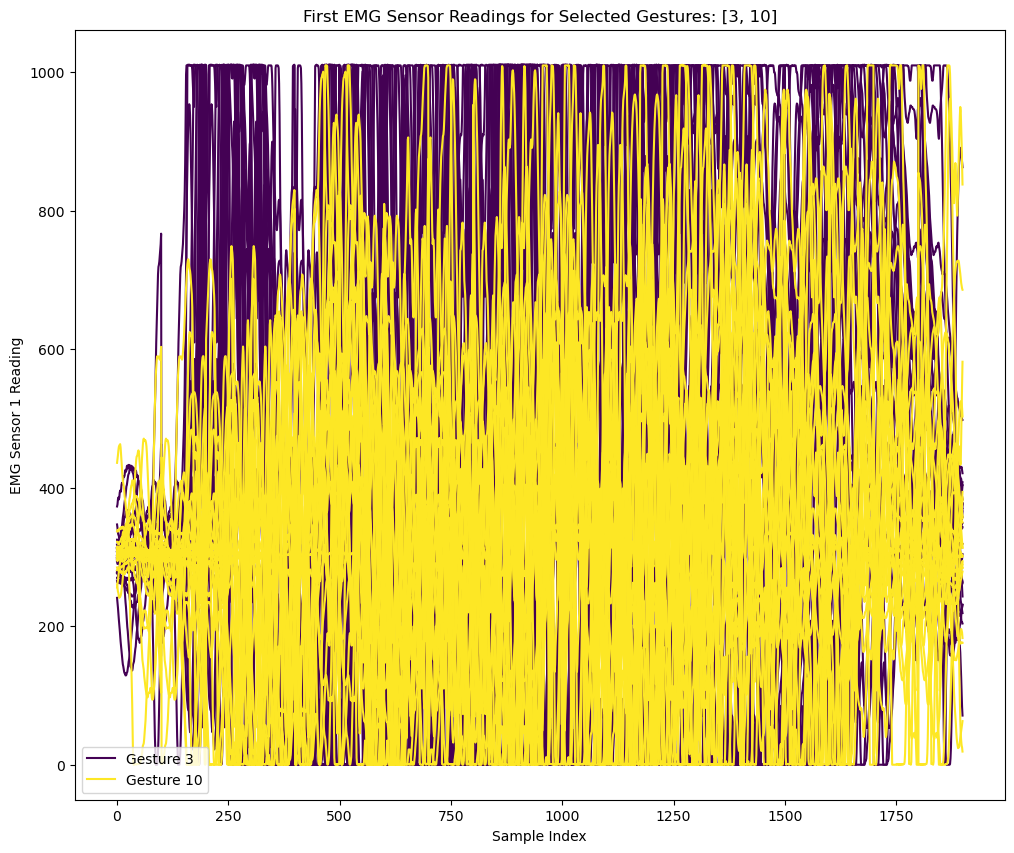

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the root path where processed data is stored

# Load processed data
data_path = os.path.join(root_path, "processed_gesture_data.npy")
label_path = os.path.join(root_path, "gesture_labels.npy")

if not os.path.exists(data_path) or not os.path.exists(label_path):
    raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")

print("Loading processed data...")
X = np.load(data_path, allow_pickle=True)
y = np.load(label_path, allow_pickle=True)

# Specify which gestures to visualize (e.g., [1, 3, 5])
selected_gestures = [3, 10]  # Change this list to choose specific gestures

# Generate colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(selected_gestures)))

# Plot first EMG sensor readings across all trials for selected gestures
plt.figure(figsize=(12, 10))
for i, label in enumerate(selected_gestures):
    if label not in np.unique(y):
        print(f"Gesture {label} not found in dataset. Skipping.")
        continue
    indices = np.where(y == label)[0]  # Get indices of trials for this gesture
    for idx in indices:
        plt.plot(X[idx, :, :, 0].flatten(), color=colors[i], label=f"Gesture {label}" if idx == indices[0] else "")

plt.xlabel("Sample Index")
plt.ylabel("EMG Sensor 1 Reading")
plt.title(f"First EMG Sensor Readings for Selected Gestures: {selected_gestures}")
plt.legend()
plt.show()


Loading processed data...


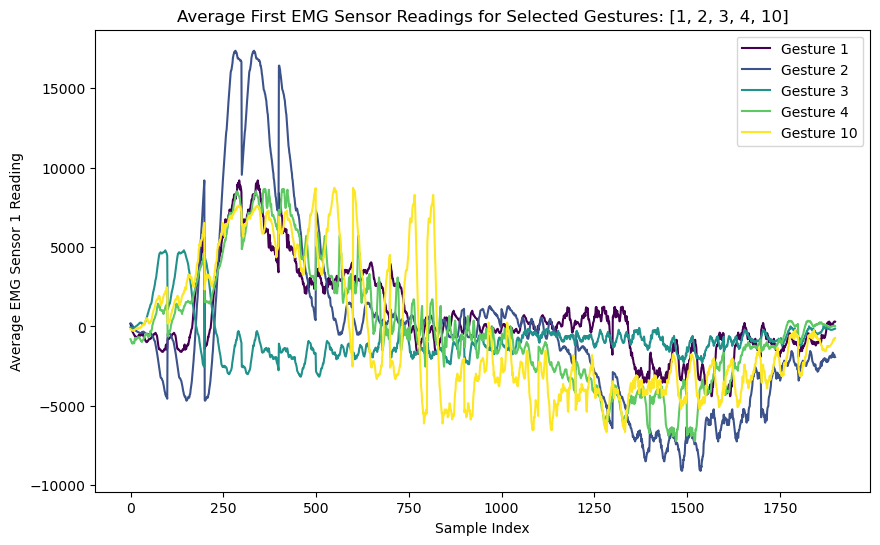

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the root path where processed data is stored

# Load processed data
data_path = os.path.join(root_path, "processed_gesture_data.npy")
label_path = os.path.join(root_path, "gesture_labels.npy")

if not os.path.exists(data_path) or not os.path.exists(label_path):
    raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")

print("Loading processed data...")
X = np.load(data_path, allow_pickle=True)
y = np.load(label_path, allow_pickle=True)

# Specify which gestures to visualize (e.g., [1, 3, 5])
selected_gestures = [1, 2, 3, 4, 10]  # Change this list to choose specific gestures

# Generate colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(selected_gestures)))

# Plot the average of the first EMG sensor readings across trials for selected gestures
plt.figure(figsize=(10, 6))
for i, label in enumerate(selected_gestures):
    if label not in np.unique(y):
        print(f"Gesture {label} not found in dataset. Skipping.")
        continue
    indices = np.where(y == label)[0]  # Get indices of trials for this gesture
    trials = np.array([X[idx, :, :, 7].flatten() for idx in indices])  # Extract all trials
    avg_reading = np.mean(trials, axis=0)  # Compute average across trials
    
    plt.plot(avg_reading, color=colors[i], label=f"Gesture {label}")

plt.xlabel("Sample Index")
plt.ylabel("Average EMG Sensor 1 Reading")
plt.title(f"Average First EMG Sensor Readings for Selected Gestures: {selected_gestures}")
plt.legend()
plt.show()


Loading processed data...


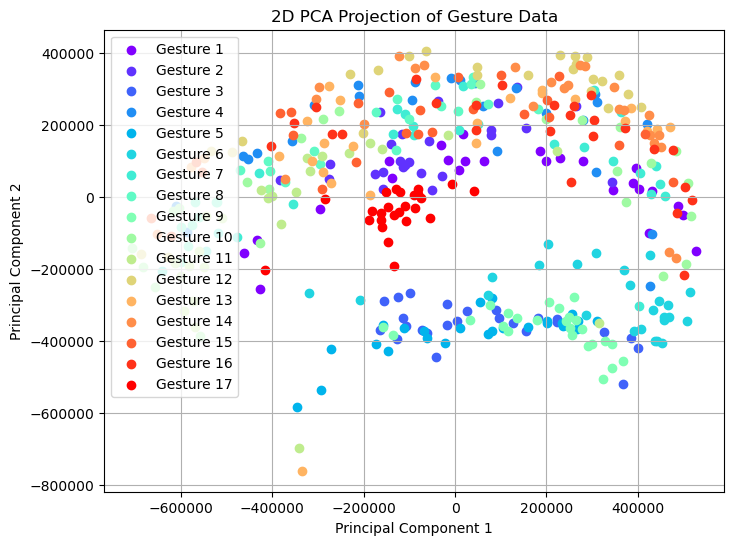

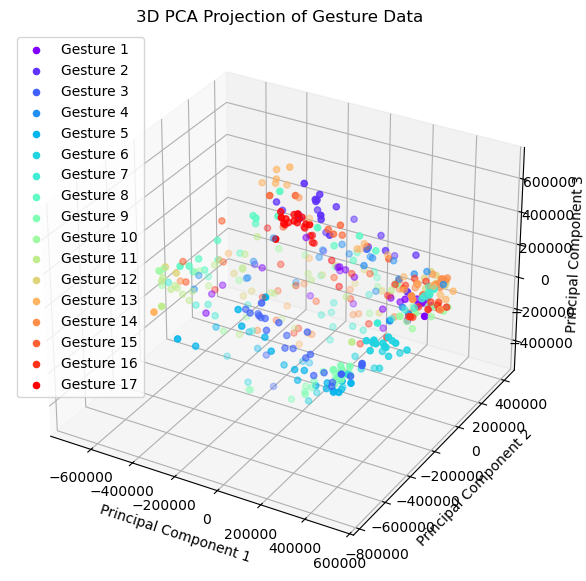

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os

# Load processed data
data_path = os.path.join(root_path, "processed_gesture_data.npy")
label_path = os.path.join(root_path, "gesture_labels.npy")

if not os.path.exists(data_path) or not os.path.exists(label_path):
    raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")

print("Loading processed data...")
X = np.load(data_path, allow_pickle=True)
y = np.load(label_path, allow_pickle=True)

# Reshape data to (num_samples, num_features) for PCA
num_samples = X.shape[0]
num_features = X.shape[1] * X.shape[2] * X.shape[3]
X_reshaped = X.reshape(num_samples, num_features)

# Perform PCA for 2D and 3D projections
pca_2d = PCA(n_components=2)
pca_3d = PCA(n_components=3)

X_pca_2d = pca_2d.fit_transform(X_reshaped)
X_pca_3d = pca_3d.fit_transform(X_reshaped)

# Generate colormap
unique_labels = np.unique(y)
cmap = plt.get_cmap("rainbow", len(unique_labels))  # "rainbow" ensures clear distinction between classes
colors = [cmap(i) for i in range(len(unique_labels))]

# 2D PCA Plot
plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    indices = np.where(y == label)[0]
    plt.scatter(X_pca_2d[indices, 0], X_pca_2d[indices, 1], color=colors[i], label=f"Gesture {label}",)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA Projection of Gesture Data")
plt.legend()
plt.grid(True)
plt.show()

# 3D PCA Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for i, label in enumerate(unique_labels):
    indices = np.where(y == label)[0]
    ax.scatter(X_pca_3d[indices, 0], X_pca_3d[indices, 1], X_pca_3d[indices, 2], color=colors[i], label=f"Gesture {label}", )

ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("3D PCA Projection of Gesture Data")
ax.legend()
plt.show()



Loading processed data...


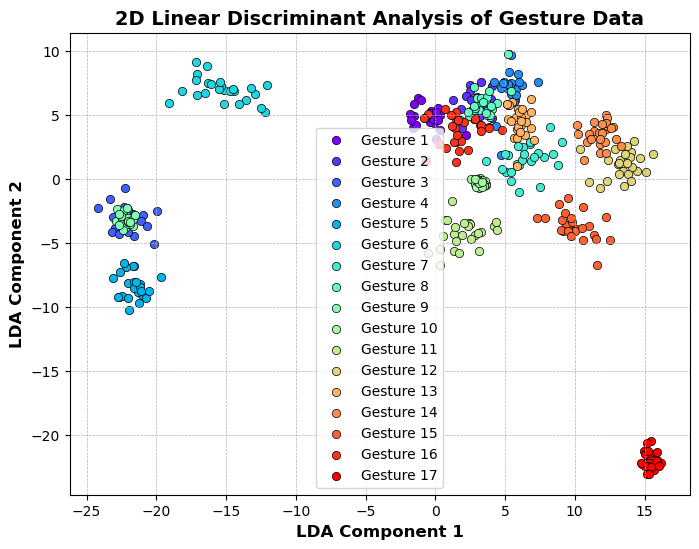

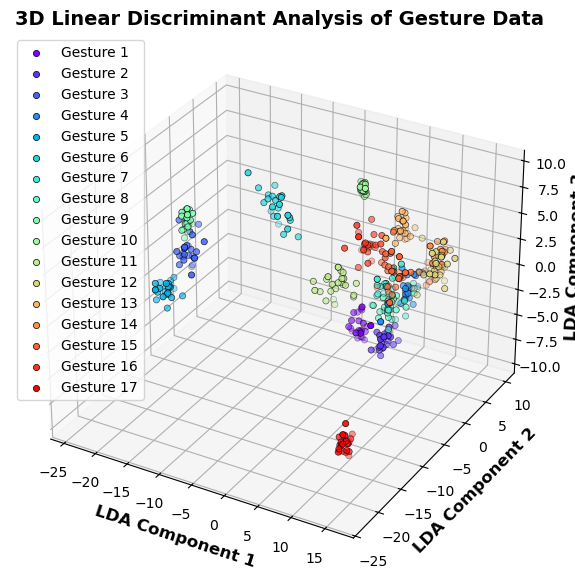

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


# Load processed data
data_path = os.path.join(root_path, "processed_gesture_data.npy")
label_path = os.path.join(root_path, "gesture_labels.npy")

if not os.path.exists(data_path) or not os.path.exists(label_path):
    raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")

print("Loading processed data...")
X = np.load(data_path, allow_pickle=True)
y = np.load(label_path, allow_pickle=True)

# Reshape data to (num_samples, num_features) for LDA
num_samples = X.shape[0]
num_features = X.shape[1] * X.shape[2] * X.shape[3]
X_reshaped = X.reshape(num_samples, num_features)

# Perform LDA for 2D and 3D projections
lda_2d = LDA(n_components=2)
lda_3d = LDA(n_components=3)

X_lda_2d = lda_2d.fit_transform(X_reshaped, y)
X_lda_3d = lda_3d.fit_transform(X_reshaped, y)

# Generate a distinct color map for better visualization
unique_labels = np.unique(y)
cmap = plt.get_cmap("rainbow", len(unique_labels))  # "rainbow" ensures clear distinction between classes
colors = [cmap(i) for i in range(len(unique_labels))]

# 2D LDA Plot with improved academic presentation
plt.figure(figsize=(8, 6))
for i, label in enumerate(unique_labels):
    indices = np.where(y == label)[0]
    plt.scatter(X_lda_2d[indices, 0], X_lda_2d[indices, 1], color=colors[i], label=f"Gesture {label}", edgecolors='black', linewidth=0.5)

plt.xlabel("LDA Component 1", fontsize=12, fontweight='bold')
plt.ylabel("LDA Component 2", fontsize=12, fontweight='bold')
plt.title("2D Linear Discriminant Analysis of Gesture Data", fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='best', frameon=True)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

# 3D LDA Plot with improved academic presentation
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for i, label in enumerate(unique_labels):
    indices = np.where(y == label)[0]
    ax.scatter(X_lda_3d[indices, 0], X_lda_3d[indices, 1], X_lda_3d[indices, 2], color=colors[i], label=f"Gesture {label}", edgecolors='black', linewidth=0.5)

ax.set_xlabel("LDA Component 1", fontsize=12, fontweight='bold')
ax.set_ylabel("LDA Component 2", fontsize=12, fontweight='bold')
ax.set_zlabel("LDA Component 3", fontsize=12, fontweight='bold')
ax.set_title("3D Linear Discriminant Analysis of Gesture Data", fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best', frameon=True)
plt.show()


Loading processed data...
KNN Accuracy: 0.6172
Number of Misclassified Points: 49


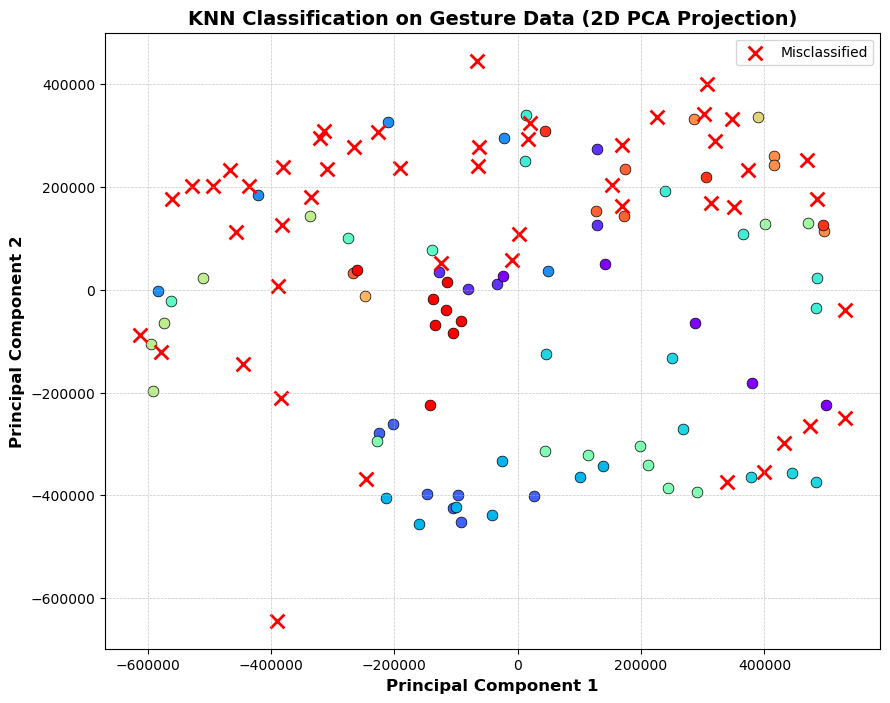

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load processed data
data_path = os.path.join(root_path, "processed_gesture_data.npy")
label_path = os.path.join(root_path, "gesture_labels.npy")

if not os.path.exists(data_path) or not os.path.exists(label_path):
    raise FileNotFoundError("Processed gesture data or labels not found. Please run process_all_gesture_files first.")

print("Loading processed data...")
X = np.load(data_path, allow_pickle=True)
y = np.load(label_path, allow_pickle=True)

# Reshape data to (num_samples, num_features) for classification
num_samples = X.shape[0]
num_features = X.shape[1] * X.shape[2] * X.shape[3]
X_reshaped = X.reshape(num_samples, num_features)

# Split the data into training and testing sets
test_size = 0.3
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=test_size, random_state=random_state, stratify=y
)

# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Compute accuracy and misclassified count
accuracy = accuracy_score(y_test, y_pred)
misclassified_count = np.sum(y_pred != y_test)
print(f"KNN Accuracy: {accuracy:.4f}")
print(f"Number of Misclassified Points: {misclassified_count}")

# Reduce test data to 2D using PCA for visualization
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Create a colormap for true labels using "rainbow"
unique_labels = np.unique(y_test)
cmap = plt.get_cmap("rainbow", len(unique_labels))
colors = [cmap(i) for i in range(len(unique_labels))]
color_dict = {label: colors[i] for i, label in enumerate(unique_labels)}

# Identify correctly classified and misclassified indices
correct_idx = np.where(y_pred == y_test)[0]
misclassified_idx = np.where(y_pred != y_test)[0]

# Plot the PCA projection with correct predictions and highlight misclassified points
plt.figure(figsize=(10, 8))

# Plot correctly classified points (color-coded by their true label)
for idx in correct_idx:
    true_label = y_test[idx]
    plt.scatter(X_test_pca[idx, 0], X_test_pca[idx, 1],
                color=color_dict[true_label], marker='o', s=60,
                edgecolors='black', linewidth=0.5)

# Highlight misclassified points with a distinct marker (red 'x')
plt.scatter(X_test_pca[misclassified_idx, 0], X_test_pca[misclassified_idx, 1],
            color='red', marker='x', s=100, label='Misclassified', linewidth=2)

plt.xlabel("Principal Component 1", fontsize=12, fontweight='bold')
plt.ylabel("Principal Component 2", fontsize=12, fontweight='bold')
plt.title("KNN Classification on Gesture Data (2D PCA Projection)", fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='best', frameon=True)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()
